In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from scipy.stats import spearmanr, pearsonr
pd.set_option('display.width', 2000)

In [3]:
nucleus_df = pd.read_csv('csv/nuclei_g4_2.csv')
image_df = pd.read_csv('csv/images_g4_2.csv')
print(nucleus_df['Location'].unique())


['DG' 'Undefined' 'CA3' nan]


In [4]:

#nucleus_df = nucleus_df[nucleus_df['CellType'].isin(['neunPositive', 'neunPositiveLow'])]
nucleus_df['CellType'] = nucleus_df['CellType'].replace('neunPositiveLow', 'neunPositive')

merged_df = pd.merge(nucleus_df, image_df[['ImageName','g4Background']], on='ImageName')
print(merged_df)
# Assuming 'df' is your DataFrame
print(len(nucleus_df[nucleus_df['CellType']=='neunPositiveLow']))
print(nucleus_df['Location'].unique())

       Condition                                          ImageName  Label    Area                                           Centroid      CellType   Location  Ch1Intensity  Ch2Intensity  Ch3Intensity  Ch4Intensity  CytoCh1Intensity  CytoCh2Intensity  CytoCh3Intensity  CytoCh4Intensity  g4Background
0         Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...      1  1311.0  (3.887109077040427, 2341.739893211289, 2699.13...  neunPositive         DG     30.109077      0.247902     42.160183     52.469108               NaN               NaN               NaN               NaN     13.994380
1         Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...      2  1537.0  (2.652569941444372, 1555.5953155497723, 2999.8...     Undefined         DG     19.577749      0.527001     67.763175     58.642811               NaN               NaN               NaN               NaN     13.994380
2         Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...      3  1794.0  (2.4520624303

   Condition                                          ImageName      CellType  g4Background  Ch3Intensity  BackgroundSubtracted
0     Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...     Undefined     13.994380     64.614256             50.619876
1     Contra  HI 1 Contralateral Mouse 8 Slide18 G4green Neu...  neunPositive     13.994380     74.958347             60.963967
2     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...     Undefined      3.326813     51.222869             47.896055
3     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...  neunPositive      3.326813     62.445271             59.118458
4     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...     Undefined      5.577969     51.658729             46.080760
5     Contra  HI 2 Contralateral Mouse 9 Slide17 G4green Neu...  neunPositive      5.577969     63.903068             58.325099
6     Contra  HI 3 Contralateral Mouse 10 Slide18 G4green Ne...     Undefined      3.313617     44.51087

c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jonasvg\AppData\Local\miniconda3\envs\image_analysis\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


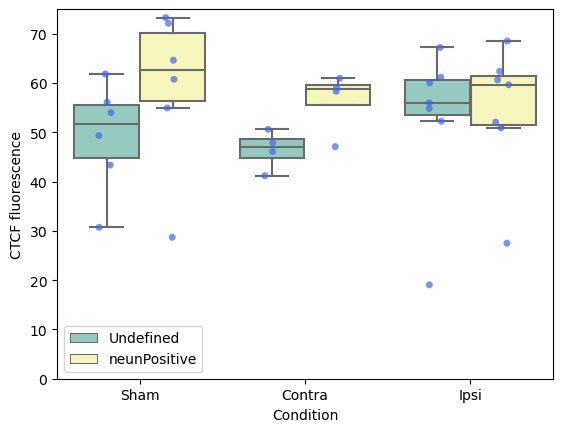

In [21]:
order =['Sham', 'Contra', 'Ipsi']

mean_ch3_intensity = nucleus_df.groupby(['Condition', 'ImageName', 'CellType'])['Ch3Intensity'].mean().reset_index()
#mean_ch3_intensity = mean_ch3_intensity.drop([8,9,10,11])
merged_ch3 = merged_df.groupby(['Condition','ImageName', 'CellType', 'g4Background'])['Ch3Intensity'].mean().reset_index()
merged_ch3['BackgroundSubtracted'] = merged_ch3['Ch3Intensity'] - merged_ch3['g4Background']

palette = sns.color_palette(['royalblue'], 2)
merged_ch3 = merged_ch3.drop([8,9,10,11])
print(merged_ch3)
boxplot = sns.boxplot(data=merged_ch3, showfliers = False, x='Condition', y='BackgroundSubtracted', hue='CellType',order=order, palette='Set3')
stripplot = sns.stripplot(data=merged_ch3, x='Condition', y='BackgroundSubtracted', order=order, dodge=True, hue='CellType', palette=palette, alpha=0.7)
handles, labels = boxplot.get_legend_handles_labels()

# Create custom legend
plt.legend(handles=handles[:2], labels=labels[:2])
plt.ylim([0,75])
plt.ylabel('CTCF fluorescence')
plt.savefig('plots/G4NeuronsBackgroundSubtracted.pdf')
plt.show()

In [19]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(mean_ch3_intensity.keys())

neun_positive_df = merged_ch3[merged_ch3['CellType'] == 'neunPositive']

# Perform ANOVA test on filtered data
anova_results = f_oneway(neun_positive_df[neun_positive_df['Condition'] == 'Contra']['Ch3Intensity'],
                         neun_positive_df[neun_positive_df['Condition'] == 'Ipsi']['Ch3Intensity'],
                         neun_positive_df[neun_positive_df['Condition'] == 'Sham']['Ch3Intensity'])

# Perform Tukey HSD post hoc test
tukey_results = pairwise_tukeyhsd(neun_positive_df['Ch3Intensity'], neun_positive_df['Condition'])

print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

print("\nTukey HSD Results:")
print(tukey_results)

Index(['Condition', 'ImageName', 'CellType', 'Ch3Intensity'], dtype='object')
ANOVA Results:
F-statistic: 0.15318897878215795
p-value: 0.8593862264989129

Tukey HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
Contra   Ipsi  -1.8573 0.9803 -27.4384 23.7238  False
Contra   Sham   2.9324 0.9544 -23.4124 29.2773  False
  Ipsi   Sham   4.7897 0.8471 -17.9167 27.4961  False
-----------------------------------------------------
